In [38]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.one_hot import OneHotEncoder
import random
random.seed(0)

In [39]:
info = pd.read_csv('data/heroes_information.csv')
powers = pd.read_csv('data/super_hero_powers.csv')

df = pd.merge(info,powers,left_on='name',right_on='hero_names',how='inner').drop(columns='Unnamed: 0')
del powers, info

In [40]:
cols = ['name','hero_names']
df = df.drop(columns=cols).fillna(0)
df['Alignment'] = df['Alignment'].replace('good',1).replace('bad',0).replace('-',0).replace('neutral',1)

In [41]:
df.shape

(660, 176)

In [42]:
cols_enc = ['Gender','Eye color', 'Race', 'Hair color','Skin color','Publisher']

ohe = OneHotEncoder(use_cat_names=True,cols=cols_enc)

df = ohe.fit_transform(df).drop(columns='Gender_Male')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [43]:
df.shape

(660, 328)

In [44]:
for col in df.columns:
    if df[col].dtypes != object:
        if df[col].sum() < 50:
            df.drop(col, inplace=True, axis=1)
        else:
            df[col] = df[col].astype(int)

In [45]:
df.shape

(660, 50)

# Machine Learning

## Label Engineering

In [47]:
df['label'] = df['Longevity']*df['Alignment']
df = df.drop(columns=['Longevity'])
df = df.drop(columns=['Alignment'])

In [48]:
df.label.value_counts()

0    585
1     75
Name: label, dtype: int64

In [49]:
X = df.drop(columns='label')
y = df[['label']]

In [50]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score,classification_report
import shap
from tqdm import tqdm
import xgboost

In [51]:
%%time
loo = LeaveOneOut()
res = []
rf = RandomForestClassifier(n_estimators=20)
for train, test in tqdm(loo.split(X)):
    X_train, X_test, y_train, y_test = (
        X.values[train],
        X.values[test],
        y.values[train].ravel(),
        y.values[test].ravel(),
    )
    rf.fit(X_train, y_train)
    res.append([rf.predict_proba(X_test)[:, 1][0], y_test[0]])

660it [00:22, 29.67it/s]

CPU times: user 21 s, sys: 480 ms, total: 21.5 s
Wall time: 22.2 s


In [52]:
df['preds'] =pd.DataFrame(res,columns = ['preds','real']).preds
df['real'] =pd.DataFrame(res,columns = ['preds','real']).real

In [53]:
print('Model score on LOOCV:',roc_auc_score(df.real,df.preds))

Model score on LOOCV: 0.728945868945869


In [54]:
print(classification_report(df.real,df.preds>0.5))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       585
           1       0.43      0.08      0.13        75

    accuracy                           0.88       660
   macro avg       0.66      0.53      0.54       660
weighted avg       0.84      0.88      0.85       660



In [55]:
print('GENDER FEMALE')
print(classification_report(df[df['Gender_Female']==1].real,df[df['Gender_Female']==1].preds>0.5))
print('GENDER MALE')
print(classification_report(df[df['Gender_Female']==0].real,df[df['Gender_Female']==0].preds>0.5))

GENDER FEMALE
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       167
           1       0.00      0.00      0.00        11

    accuracy                           0.93       178
   macro avg       0.47      0.50      0.48       178
weighted avg       0.88      0.93      0.91       178

GENDER MALE
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       418
           1       0.46      0.09      0.16        64

    accuracy                           0.87       482
   macro avg       0.67      0.54      0.54       482
weighted avg       0.82      0.87      0.82       482



In [56]:
print('RACE HUMAN')
print(classification_report(df[df['Race_Human']==1].real,df[df['Race_Human']==1].preds>0.5))
print('RACE MUTANT')
print(classification_report(df[df['Race_Mutant']==0].real,df[df['Race_Mutant']==0].preds>0.5))

RACE HUMAN
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       176
           1       0.67      0.11      0.18        19

    accuracy                           0.91       195
   macro avg       0.79      0.55      0.57       195
weighted avg       0.89      0.91      0.88       195

RACE MUTANT
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       527
           1       0.42      0.07      0.12        71

    accuracy                           0.88       598
   macro avg       0.65      0.53      0.53       598
weighted avg       0.83      0.88      0.84       598



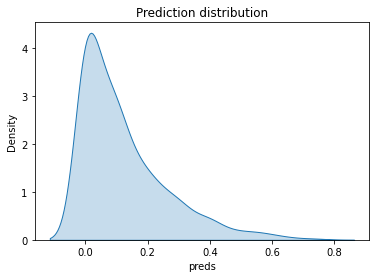

In [57]:
plt.figure()
plt.title('Prediction distribution')
sns.kdeplot(df.preds,fill=True)
plt.show()

In [61]:
selected = df.sort_values('preds',ascending=False).tail(20)

In [62]:
print('Percentage of male in top 50:',selected['Gender_Female'].value_counts(normalize=True)[0])
print('Percentage of male in all',np.round(df['Gender_Female'].value_counts(normalize=True)[0],decimals=2))

Percentage of male in top 50: 0.65
Percentage of male in all 0.73


In [63]:
print('Percentage of Humans',selected['Race_Human'].value_counts(normalize=True)[0])
print('Percentage of Humans in all',np.round(df['Race_Human'].value_counts(normalize=True)[0],decimals=2))

Percentage of Humans 0.9
Percentage of Humans in all 0.7


In [64]:
selected

,Gender_Female,Eye color_blue,Eye color_green,Eye color_brown,Eye color_-,Race_Human,Race_-,Race_Mutant,Hair color_No Hair,Hair color_Black,Hair color_Blond,Hair color_Brown,Hair color_-,Height,Publisher_Marvel Comics,Publisher_DC Comics,Skin color_-,Weight,Agility,Accelerated Healing,Durability,Stealth,Energy Absorption,Flight,Marksmanship,Weapons Master,Intelligence,Super Strength,Telepathy,Energy Blasts,Size Changing,Stamina,Super Speed,Weapon-based Powers,Teleportation,Enhanced Senses,Telekinesis,Jump,Shapeshifting,Immortality,Reflexes,Invulnerability,Force Fields,Psionic Powers,Enhanced Hearing,Energy Manipulation,Natural Weapons,Toxin and Disease Resistance,label,preds,real
118,1,0,0,0,1,0,1,0,0,0,0,0,1,-99,0,0,1,-99,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
418,0,0,0,0,1,0,1,0,0,0,0,0,1,-99,0,0,1,-99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
420,0,1,0,0,0,0,1,0,0,0,0,0,0,193,0,1,1,90,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0
425,0,0,0,1,0,0,1,0,0,1,0,0,0,175,1,0,1,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
456,0,0,0,0,1,0,1,0,0,0,0,0,1,-99,0,0,1,-99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
115,0,1,0,0,0,0,1,0,0,0,0,1,0,183,0,1,1,86,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
428,1,1,0,0,0,0,1,0,0,0,0,0,0,173,1,0,1,61,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
429,0,1,0,0,0,0,1,0,0,0,0,1,0,180,1,0,1,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
108,0,0,0,1,0,0,1,0,0,0,0,1,0,175,1,0,1,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
107,0,0,0,0,1,0,1,0,0,0,0,1,0,-99,1,0,1,-99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0


In [ ]:
Fire -- Longevity and Alignment

In [70]:
X.iloc[442]

Gender_Female                     0
Eye color_blue                    1
Eye color_green                   0
Eye color_brown                   0
Eye color_-                       0
Race_Human                        1
Race_-                            0
Race_Mutant                       0
Hair color_No Hair                0
Hair color_Black                  1
Hair color_Blond                  0
Hair color_Brown                  0
Hair color_-                      0
Height                          178
Publisher_Marvel Comics           0
Publisher_DC Comics               1
Skin color_-                      1
Weight                           79
Agility                           1
Accelerated Healing               0
Durability                        0
Stealth                           1
Energy Absorption                 0
Flight                            0
Marksmanship                      1
Weapons Master                    1
Intelligence                      1
Super Strength              

## Shap values

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[08:16:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


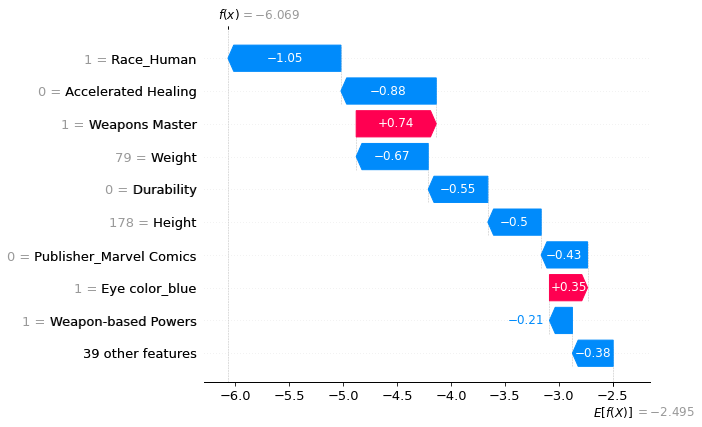

In [68]:
model = xgboost.XGBClassifier().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[442])

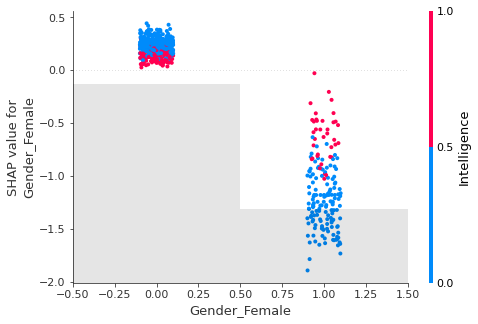

In [67]:
shap.plots.scatter(shap_values[:,"Gender_Female"], color=shap_values)

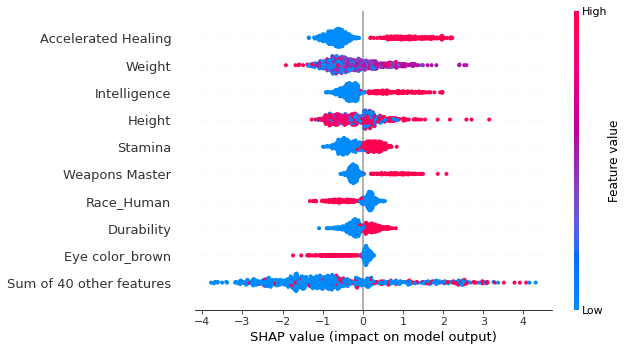

In [26]:
shap.plots.beeswarm(shap_values)

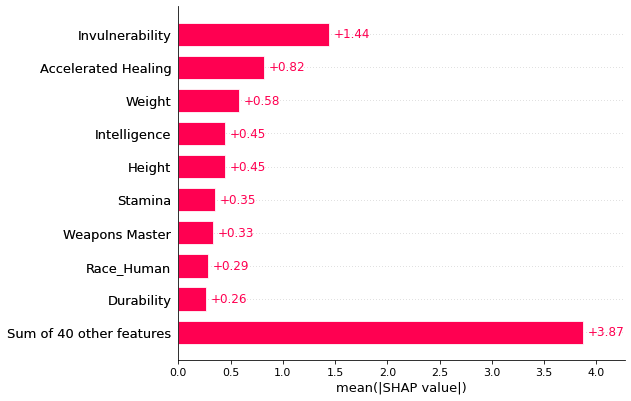

In [27]:
shap.plots.bar(shap_values)

## Predicting Gender

In [28]:
new_X = X.copy()
new_X['prev_target'] = y

new_y = new_X['Race_Human']
new_X = X.drop(columns='Race_Human')

In [29]:
new_X = new_X.drop(columns=['Weight','Height','Stamina'])

In [30]:
model = RandomForestRegressor(n_estimators=20,max_depth=5,bootstrap=True).fit(new_X, new_y)


In [31]:
#print('Model score on LOOCV:',roc_auc_score(new_y,model.predict_proba(new_X)[:,1]))
print('Model score on LOOCV:',roc_auc_score(new_y,model.predict(new_X)))

Model score on LOOCV: 0.9651447477253929


In [32]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(new_X)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])

In [33]:
#shap.plots.scatter(shap_values[:,"Gender_Female"], color=shap_values)

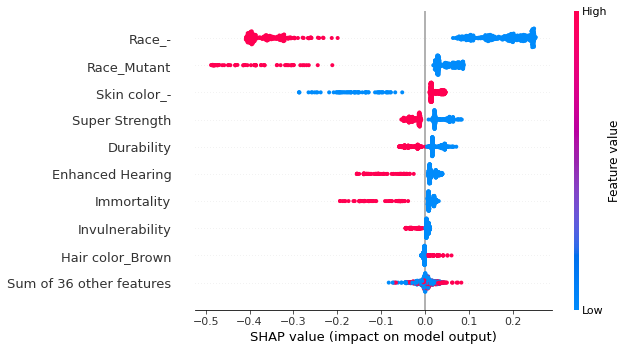

In [34]:
shap.plots.beeswarm(shap_values)

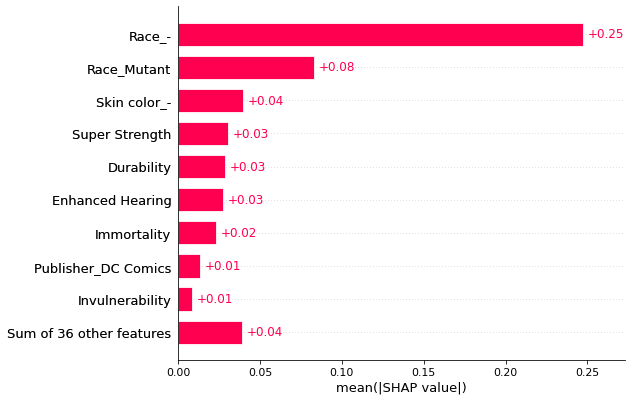

In [35]:
shap.plots.bar(shap_values)